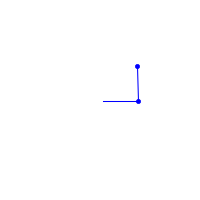

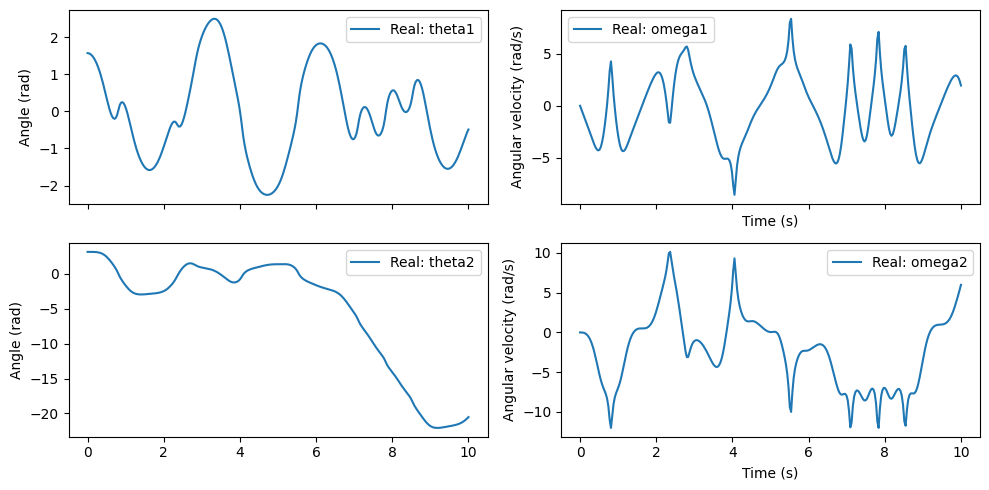

In [1]:
# from ..tests.test_bidiag_JVP_and_VJP_jax import bidiagonalize_vjpable
import jax
import jax.numpy as jnp
from jax import jit
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import Image
from pendulum_utils import (
    simulate_double_pendulum,
    save_and_display_animation,
    plot_pendulum_state,
)

# Parameters and simulation
params = (1.0, 1.0, 1.0, 1.0, 9.81)  # masses, lengths, gravity
initial_state = jnp.array([jnp.pi / 2, 0.0, jnp.pi, 0.0])
fps = 1 / 0.03355705
seconds = 10.0
t = jnp.linspace(0.0, seconds, int(fps * seconds))
trajectory = simulate_double_pendulum(initial_state, t, params)

axs = plot_pendulum_state(trajectory, t, "Real")

save_and_display_animation(trajectory, fps, "real_pendulum", override_existing=True)

(4, 4)
[[ 9.95761156e-01  3.34775634e-02  1.04419472e-04 -8.61491499e-05]
 [-2.47940943e-01  9.74983215e-01  5.88167552e-03 -3.13208369e-03]
 [ 7.51146465e-04 -1.11678804e-04  9.99700010e-01  3.39809209e-02]
 [ 4.04142588e-02 -2.43528257e-03 -1.70576740e-02  1.00806844e+00]]


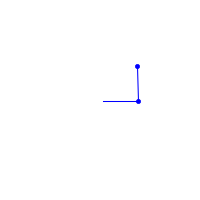

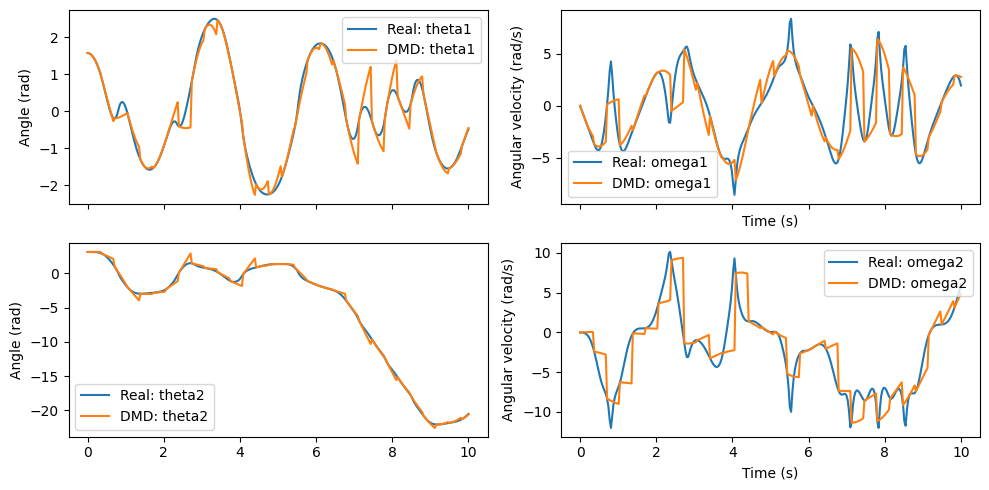

In [2]:
# Construct DMD dataset: X = [x0...x_{n-1}], X' = [x1...x_n]
X1 = trajectory[:-1].T  # shape (4, T-1)
X2 = trajectory[1:].T  # shape (4, T-1)

A_dmd, resid, rank, s = jnp.linalg.lstsq(X1.T, X2.T)
print(A_dmd.shape)

A_dmd = A_dmd.T

# Perform SVD on X1
U, S, Vh = np.linalg.svd(X1, full_matrices=False)

# Truncate rank (optional)
r = 4  # full rank
Ur = U[:, :r]
Sr = np.diag(S[:r])
Vr = Vh[:r, :]

# Compute Koopman (DMD) matrix
# A_tilde = Ur.T @ X2 @ Vr.T @ np.linalg.inv(Sr)
# A_dmd = X2 @ Vr.T @ np.linalg.inv(Sr) @ Ur.T
print(A_dmd)

# Predict forward from x_0 using DMD
x_pred = [X1[:, 0]]
for _ in range(len(X1.T)):
    if _ % 10 == 0:
        x_pred.append(trajectory[_ + 1])
    else:
        x_pred.append(A_dmd @ x_pred[-1])
x_pred = np.stack(x_pred, axis=1).T  # shape (T-1, 4)

axs = plot_pendulum_state(trajectory, t, "Real")
plot_pendulum_state(x_pred, t, "DMD", axs)

save_and_display_animation(x_pred, fps, "DMD_pendulum", override_existing=True)

In [3]:
import sys

sys.path.append("..")  # or the full path to your project root if needed

from train_tools import train_koopman_model

with jax.debug_nans(True):
    model, koopman_op = train_koopman_model(
        trajec=trajectory, latent_dim=50, lr=5e-4, steps=3000, matvecs=10, seed=1
    )

Step 0 | Loss: 610.81306
Step 100 | Loss: 30.96848
Step 200 | Loss: 9.76309
Step 300 | Loss: 11.35576
Step 400 | Loss: 8.36870
Step 500 | Loss: 52.12101
Step 600 | Loss: 22.13643
Step 700 | Loss: 64.63548
Step 800 | Loss: 26.96511
Step 900 | Loss: 12.98381
Step 1000 | Loss: 7.13648
Step 1100 | Loss: 6.01419
Step 1200 | Loss: 2.64063
Step 1300 | Loss: 2.41135
Step 1400 | Loss: 16.63869
Step 1500 | Loss: 6.54517
Step 1600 | Loss: 2.64108
Step 1700 | Loss: 1.48309
Step 1800 | Loss: 1.00401
Step 1900 | Loss: 0.90471
Step 2000 | Loss: 0.78830
Step 2100 | Loss: 0.50223
Step 2200 | Loss: 0.35926
Step 2300 | Loss: 0.54720
Step 2400 | Loss: 0.25549
Step 2500 | Loss: 0.28868
Step 2600 | Loss: 0.29774
Step 2700 | Loss: 0.15457
Step 2800 | Loss: 0.15707
Step 2900 | Loss: 0.13675


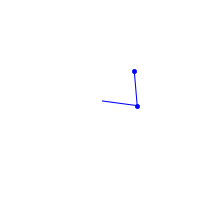

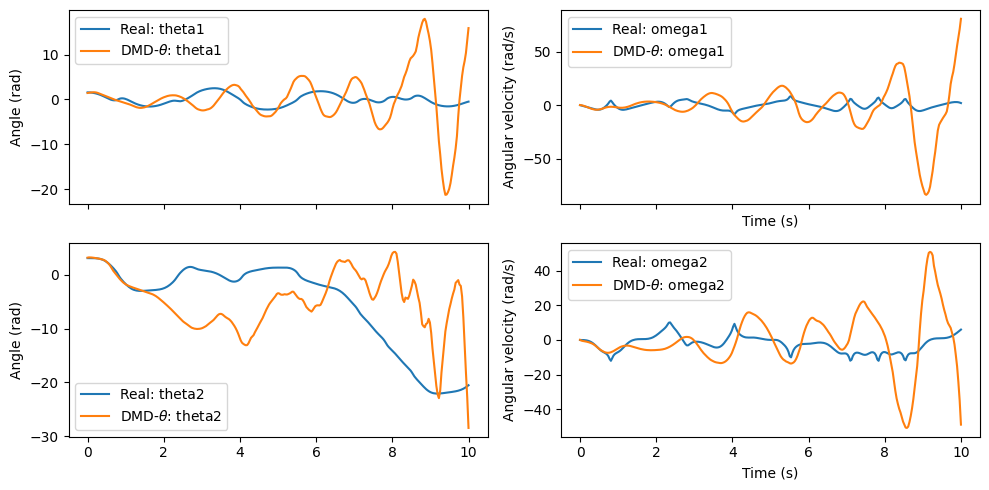

In [4]:
# phi_next_hat = (A_koop @ phi_t.T).T  # (T-1, k)
# x_next_hat = jax.vmap(model.decode)(phi_next_hat)

all_encoded = jax.vmap(lambda x: model.encode(x))(trajectory)
latent_seq = [model.encode(trajectory[0, :])]
for g in range(len(trajectory) - 1):
    if True:  # (g % 5) + 1 <= 4:
        latent_seq.append(koopman_op @ latent_seq[-1])
    else:
        latent_seq.append(all_encoded[g + 1])
latent_seq = np.stack(latent_seq, axis=1).T  # shape (T-1, 4)
decoded = jax.vmap(lambda x: model.decode(x))(latent_seq)

# save_and_display_animation(decoded, 1.0, "trained_DMD_pendul")
axs = plot_pendulum_state(trajectory, t, "Real")
plot_pendulum_state(decoded, t[: len(decoded)], r"DMD-$\theta$", axs)
# make gif:
save_and_display_animation(decoded, fps, "latent_DMD_pendulum", override_existing=True)
